# Notebook 12 b) Aspect Prediction with Neural Network Models

This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns. The output is therefore MULTICLASS.

* Section 1 - Import libraries and dataset
* Section 2 - Data cleaning
* Section 3 - Data preprocessing
* Section 4 - Building an aspect classifier with Keras embeddings (accommodation)
* Section 5 - Building an aspect classifier with Keras embeddings (food)
* Section 6 - Building an aspect classifier with Keras embeddings (attractions)
* Section 7 - Data augmentation methods on the attractions data (attractions)
* Section 8 - Running the classifier models with Word2Vec pre-trained embeddings
* Section 9 - Running the classifier models with Word2Vec custom embeddings
* Section 10 - Summary Tables

Dataset needed to run this notebook:

* combinedaspectcheck.xlsx

# Section 1: Import libraries and dataset

In [446]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
import seaborn as sns
import gensim.downloader as api
import gensim.utils
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE
import os
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight
import joblib
import warnings
warnings.filterwarnings('ignore')

In [447]:
# Bring in manually annotated accommodation data from spreadsheet file
df_accom = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDACCOM",engine = "openpyxl")
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD", engine = "openpyxl")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT", engine = "openpyxl")

In [448]:
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

# Section 2: Data Cleaning

## Accommodation

In [449]:
df_accom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2220 non-null   int64  
 1   Cleaned       2220 non-null   object 
 2   Noun Phrases  2220 non-null   object 
 3   Nouns         2220 non-null   object 
 4   Aspect        2220 non-null   object 
 5   Sentiment     2220 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 104.2+ KB


In [450]:
# Aspect value counts
df_accom["Aspect"].value_counts()

Staff            350
Room             350
Food             350
Hotel            349
Entertainment    348
Value            250
Location         215
location           5
entertainment      2
hotel              1
Name: Aspect, dtype: int64

In [451]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [452]:
df_accom["Aspect"].value_counts()

Staff            350
Entertainment    350
Hotel            350
Room             350
Food             350
Value            250
Location         220
Name: Aspect, dtype: int64

Mostly balanced categories, the two smaller categories represent those where all datapoints were used but there were just fewer overall.

## Food

In [453]:
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       2100 non-null   int64  
 1   Cleaned       2097 non-null   object 
 2   Noun Phrases  2100 non-null   object 
 3   Nouns         2100 non-null   object 
 4   Sentiment     2100 non-null   float64
 5   Aspect        2100 non-null   object 
 6   Orig Aspect   2100 non-null   object 
 7   Column1       0 non-null      float64
dtypes: float64(2), int64(1), object(5)
memory usage: 131.4+ KB


In [454]:
# Aspect value counts
df_food["Aspect"].value_counts()

Meal Exp         350
Menu Choice      350
Value            350
Staff&Service    350
Visit Exp        350
Food Quality     350
Name: Aspect, dtype: int64

Balanced aspect categories

## Attractions

In [455]:
df_attract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrigInd       1650 non-null   int64  
 1   Cleaned       1650 non-null   object 
 2   Noun Phrases  1650 non-null   object 
 3   Nouns         1650 non-null   object 
 4   Sentiment     1650 non-null   float64
 5   Aspect        1650 non-null   object 
 6   OrigAspect    1648 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 90.4+ KB


In [456]:
# Aspect value counts
df_attract["Aspect"].value_counts()

Activities       300
Nature           300
Amenities        300
VisitExp&Gen     250
Staff&Service    200
History          150
Value            150
Name: Aspect, dtype: int64

Unbalanced aspect categories due to not many datapoints available in the original dataset for some of the categories

# Section 3: Data preprocessing

## Define X and y

In [457]:
# Function to split the data between X and y

def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [458]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


## Train test split

In [459]:
# Train, validation, test split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True, random_state = 1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True, random_state = 1)
    return X_train,X_val, X_test, y_train,y_val,y_test

In [460]:
# Run function for each category
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [461]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


In [462]:
# Get maximum number of nouns to use in the 'maxlen' arguement
print(pd.DataFrame(X_train_accom)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_food)["Nouns"].str.split().apply(len).max())
print(pd.DataFrame(X_train_attract)["Nouns"].str.split().apply(len).max())

10
9
9


## Encode y and X

In [463]:
# Function to encode y values as one-hot encoded for hold-out model

def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [464]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)

def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.fit_transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l,y_val_l, y_test_l

In [465]:
# Apply function
y_train_accom_e, y_val_accom_e, y_test_accom_e = bin(y_train_accom, y_val_accom, y_test_accom)
y_train_food_e, y_val_food_e, y_test_food_e = bin(y_train_food, y_val_food, y_test_food)
y_train_attract_e, y_val_attract_e, y_test_attract_e = bin(y_train_attract, y_val_attract, y_test_attract)

y_train_accom_l, y_val_accom_l, y_test_accom_l = lab(y_train_accom, y_val_accom, y_test_accom)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
y_train_attract_l, y_val_attract_l, y_test_attract_l = lab(y_train_attract, y_val_attract, y_test_attract)

### Keras Word Embeddings

In [466]:
# Function to fit tokenizer on text and transform to padded word embeddings

def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [467]:
# Apply function to X training, validation and test sets
accom_tok, X_train_accom_w, X_val_accom_w, X_test_accom_w = tok(X_train_accom, X_val_accom, X_test_accom)
food_tok,X_train_food_w, X_val_food_w, X_test_food_w = tok(X_train_food, X_val_food, X_test_food)
attract_tok,X_train_attract_w, X_val_attract_w, X_test_attract_w = tok(X_train_attract, X_val_attract, X_test_attract)

In [468]:
# Function to save test data and tokenizers as pickle file
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)
        

In [469]:
# Save out the food tokenzier as the best model for this category
save_tok('food_tokenizer.pickle',food_tok)

In [470]:
# Shape of y training, validation and test
print(y_train_accom_e.shape, y_val_accom_e.shape, y_test_accom_e.shape)
print(y_train_food_e.shape, y_val_food_e.shape, y_test_food_e.shape)
print(y_train_attract_e.shape, y_val_attract_e.shape, y_test_attract_e.shape)

print(y_train_accom_l.shape, y_val_accom_l.shape, y_test_accom_l.shape)
print(y_train_food_l.shape, y_val_food_l.shape, y_test_food_l.shape)
print(y_train_attract_l.shape,  y_val_attract_l.shape,y_test_attract_l.shape)

(1776, 7) (222, 7) (222, 7)
(1680, 6) (210, 6) (210, 6)
(1320, 7) (165, 7) (165, 7)
(1776,) (222,) (222,)
(1680,) (210,) (210,)
(1320,) (165,) (165,)


In [471]:
# Get shape of training, validation and test sets
print(X_train_accom_w.shape,y_train_accom_e.shape)
print(X_train_food_w.shape, y_train_food_e.shape)
print(X_train_attract_w.shape, y_train_attract_e.shape)

(1776, 20) (1776, 7)
(1680, 20) (1680, 6)
(1320, 20) (1320, 7)


In [472]:
#with open('tok_accom.pickle', 'wb') as handle:
    #pickle.dump(tok_accom, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Define general functions used for each model

In [473]:
# Visualise the training and test accuracies and losses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [474]:
# Metrics function - macro weighted to account for any class imbalance

def metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob):
    accuracy = accuracy_score(y_val_integer, y_pred_class)
    rocauc = roc_auc_score(y_val_e,y_pred_prob, average = 'macro', multi_class = 'ovr')
    precision = precision_score(y_val_integer, y_pred_class, average='macro')
    recall = recall_score(y_val_integer, y_pred_class, average='macro')
    f1 = f1_score(y_val_integer, y_pred_class, average='macro')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [475]:
# The model will use earlystopping if the valuation loss doesn't decrease after a specified number of epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir,patience):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = patience),modelcheckpoint]
    return callbacks

In [476]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class,labels):
    classification = classification_report(y_val_integer, y_pred_class)
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    sns.heatmap(cf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues,xticklabels = labels,yticklabels = labels)
    ax.set_xlabel('Predicted',labelpad = 10)
    ax.set_ylabel('Actual',labelpad = 10)
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)
    plt.show()


In [477]:
# Weight adjustments if required

def weight(y_train):
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    return class_weights

In [478]:
#, input_shape=(1600,))

In [479]:
# Model with output of 7 classes

def create_model_a():
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model
    

In [480]:
# Model with output of 6 classes

def create_model_b():
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [481]:
# Stratified KFold function using keras wrapper in scikit learn (Use X_train encoded as word embedding and y_train encoded 
# with labels NOT one-hot encoded)

def cross(X,y,create_model_a):
    model = KerasClassifier(build_fn=create_model_a, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    results = cross_val_score(model, X,y, cv=kfold)
    
    return results.mean()

In [482]:
# Function to fit model, print training and validation accuracies

def run_mod(model, X_train, X_val, y_train, y_val):
    val_acc = []
    history = model.fit(X_train, y_train,
                       epochs = epochs,
                       verbose = 2,
                       callbacks = callbacks,
                       validation_data = (X_val, y_val),
                       batch_size = batch_size,
                       class_weight = class_weights)
    print("\n\n")
    print(model.evaluate(X_train, y_train))
    print(model.evaluate(X_val, y_val))
    print("\n\n")
    plot_history(history)


In [483]:
# Evaluation function

def eval(model,output_dir,name,X_val,y_val,y_val_aspect,labels):
    model.load_weights(output_dir+name)
    y_pred_prob = model.predict(X_val)
    y_pred_class = np.argmax(model.predict(X_val), axis=-1)
    y_val_integer = np.argmax(y_val, axis=1)
    df_pred = pd.DataFrame(list(zip(y_val_integer, y_val_aspect,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
    df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
    class_conf(y_val_integer,y_pred_class,labels)
    print("\n")
    print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
    print("\n")
    return df_pred, df_wrong, y_val_integer, y_pred_class, y_pred_prob

In [484]:
# Run weights function to get weights

cw_accom = weight(y_accom)
cw_food = weight(y_food)
cw_attract = weight(y_attract)

# Section 4: Accommodation aspect classifier

In [40]:
# Set parameters

input_dim = 6000 #number of words
output_dim = 16
input_length = 20 #maximum length of embedding
batch_size = 16
epochs = 50
class_weights_accom = {0:cw_accom[0],1:cw_accom[1],2:cw_accom[2],3:cw_accom[3],4:cw_accom[4],5:cw_accom[5],6:cw_accom[6]}
n_splits = 10

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/AccomAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_accom


### Cross validation evaluation

In [41]:
# Target encoded as integers as multi-label indicator (one-hot) encoding is not supported stratified cross validation
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 7 output parameters

accom_cv = cross(X_train_accom_w, y_train_accom_l,create_model_a)
accom_cv

0.9256681382656098

### Run model

Epoch 1/50
111/111 - 0s - loss: 1.8600 - accuracy: 0.2382 - val_loss: 1.3735 - val_accuracy: 0.4820
Epoch 2/50
111/111 - 0s - loss: 0.9306 - accuracy: 0.6554 - val_loss: 0.5774 - val_accuracy: 0.8063
Epoch 3/50
111/111 - 0s - loss: 0.3517 - accuracy: 0.9071 - val_loss: 0.4423 - val_accuracy: 0.8784
Epoch 4/50
111/111 - 0s - loss: 0.1322 - accuracy: 0.9668 - val_loss: 0.4484 - val_accuracy: 0.8829
Epoch 5/50
111/111 - 0s - loss: 0.1080 - accuracy: 0.9769 - val_loss: 0.3656 - val_accuracy: 0.9099
Epoch 6/50
111/111 - 0s - loss: 0.0505 - accuracy: 0.9899 - val_loss: 0.4819 - val_accuracy: 0.9099
Epoch 7/50
111/111 - 0s - loss: 0.0421 - accuracy: 0.9904 - val_loss: 0.4949 - val_accuracy: 0.8964
Epoch 8/50
111/111 - 0s - loss: 0.0477 - accuracy: 0.9865 - val_loss: 0.5620 - val_accuracy: 0.9009
Epoch 9/50
111/111 - 0s - loss: 0.0437 - accuracy: 0.9882 - val_loss: 0.5439 - val_accuracy: 0.9009
Epoch 10/50
111/111 - 0s - loss: 0.0223 - accuracy: 0.9949 - val_loss: 0.6474 - val_accuracy: 0.8919

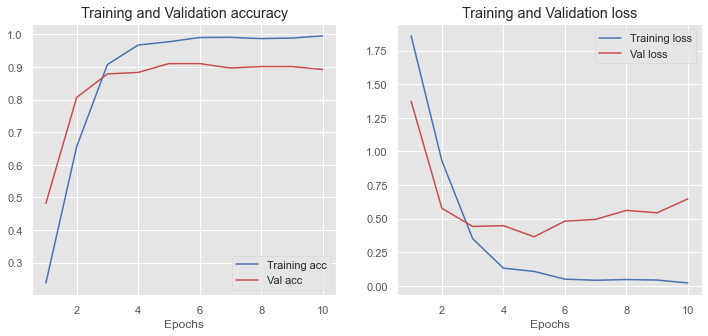

In [42]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model1 = create_model_a()
history1 = run_mod(model1, X_train_accom_w, X_val_accom_w, y_train_accom_e, y_val_accom_e)
model1.save('accom.h5')

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        35
           1       0.91      0.89      0.90        35
           2       1.00      0.91      0.96        35
           3       1.00      0.91      0.95        22
           4       0.91      0.91      0.91        35
           5       0.89      0.89      0.89        35
           6       0.92      0.96      0.94        25

    accuracy                           0.91       222
   macro avg       0.92      0.91      0.91       222
weighted avg       0.91      0.91      0.91       222



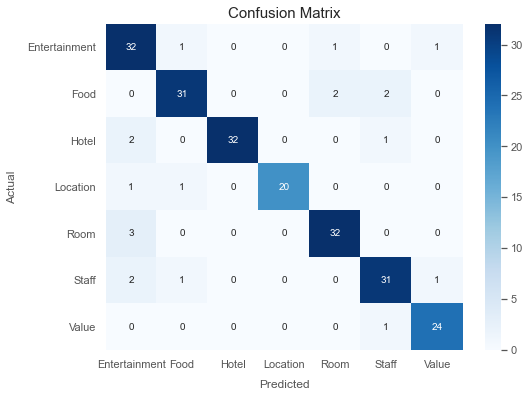



The model predicted: 20 aspects wrong from a total of: 222 predictions




In [43]:
labels_accom = ['Entertainment','Food','Hotel','Location','Room','Staff','Value']
df_pred_accom, df_wrong_accom, y_val_integer, y_pred_class, y_pred_prob = eval(model1, output_dir,"/weights.05.hdf5",X_val_accom_w, y_val_accom_e,y_val_accom,labels_accom)

In [44]:
results1 = metric_results(y_val_accom_e,y_val_integer,y_pred_class,y_pred_prob)
results1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.90991,0.919263,0.911911,0.914381,0.98987


# Section 5: Building a food aspect classifier

## Build model

In [45]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_food = {0:cw_food[0],1:cw_food[1],2:cw_food[2],3:cw_food[3],4:cw_food[4],5:cw_food[5]}

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/FoodAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_food

### Cross validation evaluation

In [46]:
# Combine training and validation sets for word embeddings and target encoded as integers as multi-label indicator (one-hot)
# encoding is not supported
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 6 output parameters

cv_food = cross(X_train_food_w, y_train_food_l,create_model_b)
cv_food

0.9470238089561462

### Run Model

Epoch 1/50
105/105 - 0s - loss: 1.7262 - accuracy: 0.2417 - val_loss: 1.2986 - val_accuracy: 0.5524
Epoch 2/50
105/105 - 0s - loss: 0.7799 - accuracy: 0.6940 - val_loss: 0.2809 - val_accuracy: 0.9333
Epoch 3/50
105/105 - 0s - loss: 0.2399 - accuracy: 0.9321 - val_loss: 0.1907 - val_accuracy: 0.9619
Epoch 4/50
105/105 - 0s - loss: 0.1254 - accuracy: 0.9661 - val_loss: 0.2171 - val_accuracy: 0.9429
Epoch 5/50
105/105 - 0s - loss: 0.0792 - accuracy: 0.9780 - val_loss: 0.2279 - val_accuracy: 0.9476
Epoch 6/50
105/105 - 0s - loss: 0.0541 - accuracy: 0.9869 - val_loss: 0.2414 - val_accuracy: 0.9524
Epoch 7/50
105/105 - 0s - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.2295 - val_accuracy: 0.9524
Epoch 8/50
105/105 - 0s - loss: 0.0339 - accuracy: 0.9887 - val_loss: 0.2668 - val_accuracy: 0.9476



53/53 [==============================] - 0s 547us/step - loss: 0.0202 - accuracy: 0.9952
[0.020160526037216187, 0.9952380657196045]
7/7 [==============================] - 0s 1ms/step - loss: 0.2668

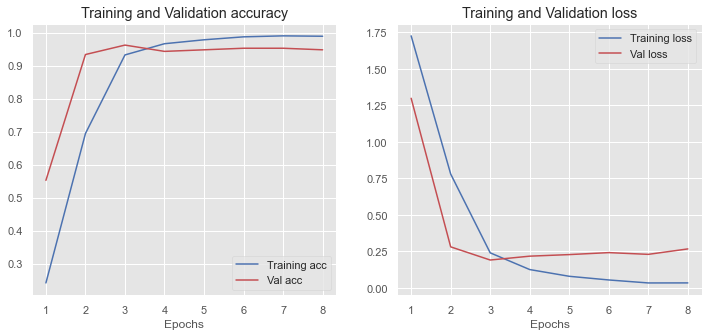

In [47]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model2 = create_model_b()
history2 = run_mod(model2, X_train_food_w, X_val_food_w, y_train_food_e, y_val_food_e)
model2.save('food.h5')

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.94      0.89      0.91        35
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        35
           4       1.00      0.94      0.97        35
           5       0.92      1.00      0.96        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



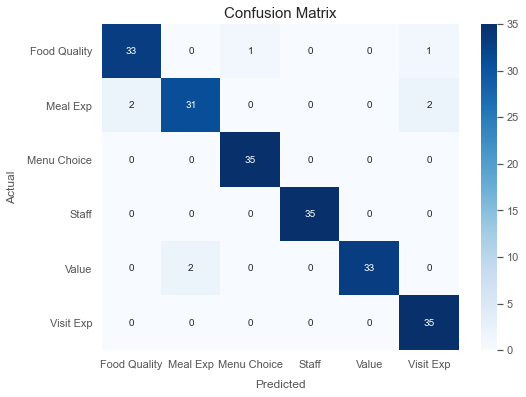



The model predicted: 8 aspects wrong from a total of: 210 predictions




In [48]:
label_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
df_pred_food, df_wrong_food, y_val_integer, y_pred_class, y_pred_prob = eval(model2, output_dir,"/weights.03.hdf5",X_val_food_w, y_val_food_e,y_val_food,label_food)

In [49]:
results2 = metric_results(y_val_food_e,y_val_integer,y_pred_class,y_pred_prob)
results2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961905,0.962588,0.961905,0.961672,0.995483


# Section 6: Building an attractions model

## Build a model

In [50]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_attract = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

output_dir = out('model_output/AtractAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_attract

### Cross validation  evaluation

In [51]:
# Combine training and validation sets for word embeddings and target encoded as integers as multi-label indicator (one-hot)
# encoding is not supported
# Run stratified cross validation and report mean accuracy for ten folds using create_model_a with 7 output parameters

cv_attract = cross(X_train_attract_w, y_train_attract_l,create_model_a)
cv_attract

0.8522727191448212

### Run Model

Epoch 1/50
83/83 - 0s - loss: 1.9461 - accuracy: 0.1530 - val_loss: 1.9470 - val_accuracy: 0.1212
Epoch 2/50
83/83 - 0s - loss: 1.8358 - accuracy: 0.2402 - val_loss: 1.5109 - val_accuracy: 0.3818
Epoch 3/50
83/83 - 0s - loss: 1.1084 - accuracy: 0.5515 - val_loss: 0.8763 - val_accuracy: 0.7818
Epoch 4/50
83/83 - 0s - loss: 0.5406 - accuracy: 0.8295 - val_loss: 0.8144 - val_accuracy: 0.8182
Epoch 5/50
83/83 - 0s - loss: 0.2725 - accuracy: 0.9333 - val_loss: 0.8876 - val_accuracy: 0.8364
Epoch 6/50
83/83 - 0s - loss: 0.1718 - accuracy: 0.9561 - val_loss: 0.9560 - val_accuracy: 0.8303
Epoch 7/50
83/83 - 0s - loss: 0.0993 - accuracy: 0.9712 - val_loss: 1.1157 - val_accuracy: 0.8364
Epoch 8/50
83/83 - 0s - loss: 0.0669 - accuracy: 0.9818 - val_loss: 1.2432 - val_accuracy: 0.8485
Epoch 9/50
83/83 - 0s - loss: 0.0552 - accuracy: 0.9841 - val_loss: 1.3389 - val_accuracy: 0.8485



42/42 [==============================] - 0s 334us/step - loss: 0.0162 - accuracy: 0.9947
[0.016217511147260666, 0.9

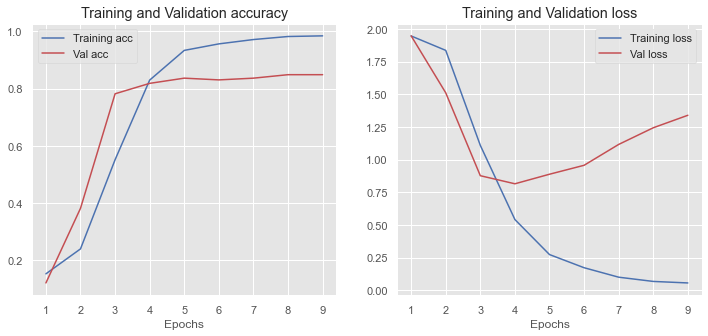

In [52]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model3 = create_model_a()
run_mod(model3, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
model3.save('attract.h5')

              precision    recall  f1-score   support

           0       0.93      0.83      0.88        30
           1       0.84      0.87      0.85        30
           2       0.81      0.87      0.84        15
           3       0.96      0.87      0.91        30
           4       0.89      0.85      0.87        20
           5       0.76      0.87      0.81        15
           6       0.71      0.80      0.75        25

    accuracy                           0.85       165
   macro avg       0.84      0.85      0.85       165
weighted avg       0.86      0.85      0.85       165



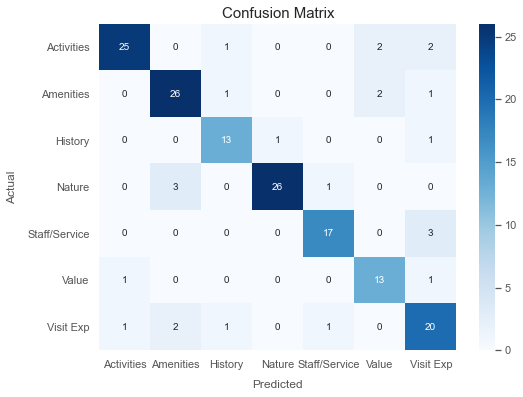



The model predicted: 25 aspects wrong from a total of: 165 predictions




In [53]:
label_attract = ["Activities","Amenities","History","Nature","Staff/Service","Value","Visit Exp"]
df_pred_attract,df_wrong_attract,y_val_integer, y_pred_class, y_pred_prob = eval(model3, output_dir,"/weights.08.hdf5",X_val_attract_w, y_val_attract_e,y_val_attract,label_attract)

In [54]:
results3 = metric_results(y_val_attract_e,y_val_integer,y_pred_class,y_pred_prob)
results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.848485,0.844832,0.85,0.845665,0.966512


### Training Accuracy Summary Results

In [55]:
train_acc = pd.DataFrame([accom_cv,cv_food, cv_attract],index = ["Accommodation","Food","Attraction"]).T
train_acc.index = ["Training Accuracy"]
train_acc = round(train_acc,4)
train_acc

,Accommodation,Food,Attraction
Training Accuracy,0.9257,0.947,0.8523


Analysis of results:

* The food model performs best, possibly because the word range is much smaller and the aspects contain fewer words.
* The accommodation and attraction models are less accurate possibly because the range of words is greater and there is more scope for classification errors to be made. Increased training data might improve the results for these categories. 
* Data augmentation is used to increase the training set size for the attractions model which is the worst performing of the three with a cross validation accuracy of 85%

# Section 6: Data Augmentation - Attractions

Augment the training data using a range of techniques such as changing, deleting, swapping words to increase the number of training samples with synthetic data based on the actual data. Whether to augment the validation set as well as the training set is a bone of contention.

https://stats.stackexchange.com/questions/320800/data-augmentation-on-training-set-only/320967#320967

On the one hand augmenting just the training is done to reduce overfitting and improve generalisation but if the augmentation is introducing samples which are different and therefore make the training set not representative, it will not perform well when it sees the validation set which does not contain the augmented samples. Some argue that the validation set should be taken from the augmented data to get a proper comparison. Performance on the validation set helps to determine which model to use. 

Based on reading the opinions from links such as above, a decision was taken to follow the usual practice of only augmenting the training data.

Cross validation is difficult here as the folds result in augmented data leaking into the test portion so instead the models are run ten times and an average accuracy taken based on that.

In [56]:
# Concat and shuffle the training data
attract_eda = pd.concat([X_train_attract,y_train_attract],axis = 1)
attract_eda = attract_eda.sample(frac=1)
attract_eda.head()

,Nouns,Aspect
27,vibrant,Activities
942,cup plate,Amenities
55,spa,Activities
13,afternoon play,Activities
33,track boardwalk dozen type waterfowl,Activities


In [57]:
attract_eda.shape

(1320, 2)

In [58]:
# Get number of words in each row, split dataframes into those with more than 1 word and those with 1
attract_eda["Count"] = attract_eda["Nouns"].apply(lambda x: len(x.split()))
attract_eda["Count"].value_counts()

1    632
2    401
3    175
4     69
5     24
6     13
7      4
8      1
9      1
Name: Count, dtype: int64

Most lines have just one word and those with more than one word have mostly two - this will inform the augmentation process

## Functions

In [59]:
# Function to create the training set based on the new augmented dataset and then tokenize and binarize the validation and test sets
# based on these new training sets.

def proc_aug(df, X_val, y_val, X_test, y_test):
    
    # Set new X_train and y_train
    X_train2 = df["Nouns"]
    y_train2 = df["Aspect"]

    # Encode new X_train, old X_val and old X_test
    tokenizer = Tokenizer(num_words = 10000)
    tokenizer.fit_on_texts(X_train2)
    X_train_s = tokenizer.texts_to_sequences(X_train2)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_attract)
    X_train_w = pad_sequences(np.array(X_train_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)
    X_val_w = pad_sequences(np.array(X_val_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"),maxlen = 20, padding = "post",truncating = "post", value = 0.0)

    # Encode new y_train and old y_val and old y_test
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train2)
    y_val_e = binarizer.fit_transform(y_val)
    y_test_e = binarizer.fit_transform(y_test)
            
    return X_train_w, y_train_e, X_val_w, y_val_e, X_test_w, y_test_e

In [60]:
# Functions to run various data augmentation functions separately on the original dataframe (DO EACH STEP SEPARATELY NOT WITH
#SINGLE FUNCTION)

def aug(df):
    
    insertion = pd.DataFrame(df["Nouns"].apply(lambda x: t.random_insertion(x, n = 1)))
    insertion = pd.concat([insertion,df.Aspect],axis = 1)
    insertion = insertion.append(df)
 
    replaced = pd.DataFrame(df["Nouns"].apply(lambda x: t.synonym_replacement(x, n = 1)))
    replaced = pd.concat([replaced,df.Aspect],axis = 1)
    replaced = replaced.append(df)

    swapped = pd.DataFrame(df["Nouns"].apply(lambda x: t.random_swap(x,n  = 1)))
    swapped = pd.concat([swapped,df.Aspect],axis = 1)
    swapped = swapped.append(df)

    swapped["Count"] = swapped["Nouns"].apply(lambda x: len(x.split()))
    equal_one = swapped[swapped["Count"]==1].reset_index()
    more_one = swapped[swapped["Count"]>1].reset_index()

    deleted = pd.DataFrame(more_one["Nouns"].apply(lambda x: t.random_deletion(x,p = 0.2)))
    deleted = pd.concat([deleted,more_one.Aspect],axis = 1,ignore_index=True)
    deleted.columns = ["Nouns","Aspect"]

    equal_one.drop(columns = "Count",axis = 1, inplace = True)
    equal_one = equal_one.set_index("index")
    deleted = deleted.append(equal_one)
    #deleted = deleted.append(df)
   
    return insertion, replaced, swapped, deleted

In [61]:
# Run model through ten times and get the average validation accuracy and training accuracy

def evaluation(model, X_train, X_val, y_train, y_val):
    train_acc = []
    val_acc = []
    for i in range(1,11):
        history = model.fit(X_train, y_train,epochs = epochs,verbose = 0,callbacks = callbacks,validation_data = (X_val, y_val),
                            batch_size = batch_size,class_weight = class_weights)
        train_acc.append(model.evaluate(X_train, y_train)[1])
        val_acc.append(model.evaluate(X_val, y_val)[1])
        train_acc_mean = sum(train_acc)/10
        val_acc_mean = sum(val_acc)/10
        
    return train_acc_mean,val_acc_mean
    

In [62]:
# Define parameters - increase the input dim to match the tokenizer above

input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_attract = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}
class_weights = class_weights_attract

output_dir = out('model_output/AttractAspectModelsAug1')
callbacks = call(output_dir,5)

## Random insertion

In [63]:
# Import easy data augmentation package and set test sentence

from textaugment import EDA
t = EDA()

test = "tasty food service"
test

'tasty food service'

In [64]:
# Random insertion one word
t.random_insertion(test, n = 1)

'servicing tasty food service'

In [65]:
# Run  augmentation function on the accommodation data
insertion, replaced, swapped, deleted = aug(attract_eda)
print(insertion.shape, replaced.shape, swapped.shape, deleted.shape)

(2640, 3) (2640, 3) (2640, 3) (2640, 2)


In [66]:
# Run encoding function on the augmented data and the original validation and test data
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(insertion, X_val_attract, y_val_attract, X_test_attract, y_val_attract)

Epoch 1/50
165/165 - 0s - loss: 1.8986 - accuracy: 0.1924 - val_loss: 1.5184 - val_accuracy: 0.3758
Epoch 2/50
165/165 - 0s - loss: 0.8889 - accuracy: 0.6780 - val_loss: 0.7895 - val_accuracy: 0.8364
Epoch 3/50
165/165 - 0s - loss: 0.3273 - accuracy: 0.9117 - val_loss: 0.7750 - val_accuracy: 0.8424
Epoch 4/50
165/165 - 0s - loss: 0.1552 - accuracy: 0.9636 - val_loss: 0.6995 - val_accuracy: 0.8667
Epoch 5/50
165/165 - 0s - loss: 0.0804 - accuracy: 0.9807 - val_loss: 0.8465 - val_accuracy: 0.8667
Epoch 6/50
165/165 - 0s - loss: 0.0674 - accuracy: 0.9860 - val_loss: 0.9817 - val_accuracy: 0.8606
Epoch 7/50
165/165 - 0s - loss: 0.0372 - accuracy: 0.9917 - val_loss: 1.1939 - val_accuracy: 0.8606
Epoch 8/50
165/165 - 0s - loss: 0.0260 - accuracy: 0.9924 - val_loss: 1.1887 - val_accuracy: 0.8667
Epoch 9/50
165/165 - 0s - loss: 0.0452 - accuracy: 0.9894 - val_loss: 1.2205 - val_accuracy: 0.8606



83/83 [==============================] - 0s 457us/step - loss: 0.0186 - accuracy: 0.9955
[0.01860

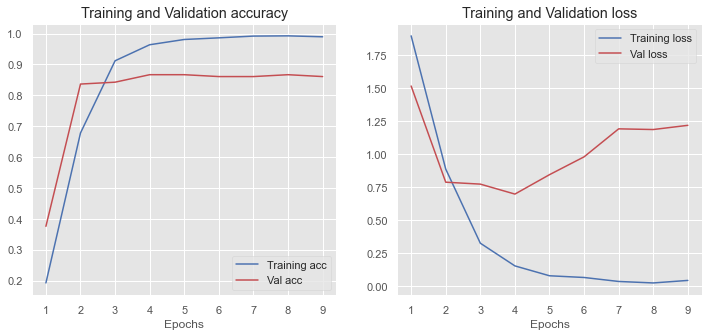

In [67]:
# Run model using the word embeddings and the target encoded as one-hot encoding
model_attract_insert = create_model_a()
run_mod(model_attract_insert, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [71]:
insert = evaluation(model_attract_insert, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
print(insert[0])
print(insert[1])

0.9976136386394501
0.8709090948104858


###  Synonym replacement

In [72]:
# Run synonym replacement
t.synonym_replacement(test,n = 1)

'tasty solid food service'

Epoch 1/50
165/165 - 0s - loss: 1.9381 - accuracy: 0.1727 - val_loss: 1.8175 - val_accuracy: 0.3636
Epoch 2/50
165/165 - 0s - loss: 1.2110 - accuracy: 0.5333 - val_loss: 0.7991 - val_accuracy: 0.7697
Epoch 3/50
165/165 - 0s - loss: 0.5509 - accuracy: 0.8114 - val_loss: 0.7818 - val_accuracy: 0.8424
Epoch 4/50
165/165 - 0s - loss: 0.2836 - accuracy: 0.9182 - val_loss: 0.8370 - val_accuracy: 0.8242
Epoch 5/50
165/165 - 0s - loss: 0.1801 - accuracy: 0.9523 - val_loss: 0.9624 - val_accuracy: 0.8061
Epoch 6/50
165/165 - 0s - loss: 0.1127 - accuracy: 0.9716 - val_loss: 1.1217 - val_accuracy: 0.8121
Epoch 7/50
165/165 - 0s - loss: 0.0996 - accuracy: 0.9750 - val_loss: 0.9921 - val_accuracy: 0.8182
Epoch 8/50
165/165 - 0s - loss: 0.0693 - accuracy: 0.9830 - val_loss: 1.0875 - val_accuracy: 0.8424



83/83 [==============================] - 0s 445us/step - loss: 0.0285 - accuracy: 0.9924
[0.028495468199253082, 0.9924242496490479]
6/6 [==============================] - 0s 499us/step - loss: 1.08

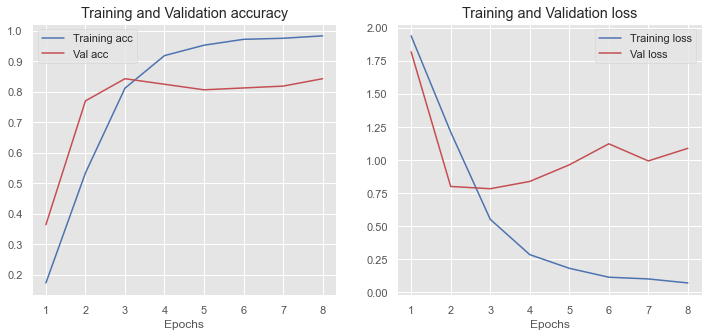

In [73]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug2')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(replaced, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_replace = create_model_a()
history_attract_replace = run_mod(model_attract_replace, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [75]:
rep = evaluation(model_attract_replace, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
print(rep[0])
print(rep[1])

0.994621217250824
0.8436363637447357


### Random swap

Randomly swap two words in the augmented text

In [76]:
# Randomly swap words in the sentence 
t.random_swap(test, n = 1)

'tasty service food'

Epoch 1/50
165/165 - 0s - loss: 1.8989 - accuracy: 0.1936 - val_loss: 1.4772 - val_accuracy: 0.3939
Epoch 2/50
165/165 - 0s - loss: 0.8337 - accuracy: 0.6898 - val_loss: 0.6883 - val_accuracy: 0.8061
Epoch 3/50
165/165 - 0s - loss: 0.2510 - accuracy: 0.9295 - val_loss: 0.7655 - val_accuracy: 0.8424
Epoch 4/50
165/165 - 0s - loss: 0.1371 - accuracy: 0.9655 - val_loss: 0.7501 - val_accuracy: 0.8303
Epoch 5/50
165/165 - 0s - loss: 0.0808 - accuracy: 0.9765 - val_loss: 0.8506 - val_accuracy: 0.8606
Epoch 6/50
165/165 - 0s - loss: 0.0515 - accuracy: 0.9871 - val_loss: 0.9221 - val_accuracy: 0.8727
Epoch 7/50
165/165 - 0s - loss: 0.0379 - accuracy: 0.9902 - val_loss: 0.8034 - val_accuracy: 0.8848



83/83 [==============================] - 0s 445us/step - loss: 0.0148 - accuracy: 0.9943
[0.014785734936594963, 0.9943181872367859]
6/6 [==============================] - 0s 499us/step - loss: 0.8034 - accuracy: 0.8848
[0.8034416437149048, 0.8848484754562378]





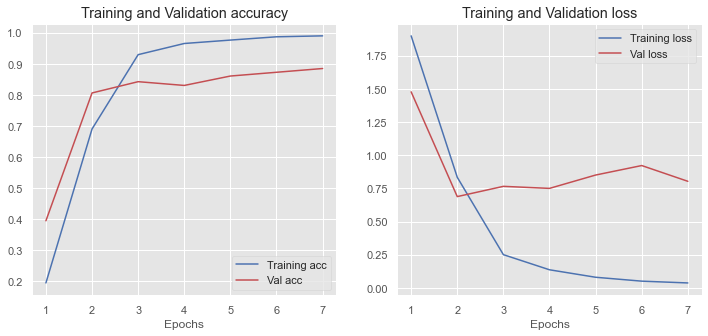

In [77]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug3')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(swapped, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_swap = create_model_a()
history_attract_swap = run_mod(model_attract_swap, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [79]:
#swap = evaluation(model_attract_swap, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
print(swap[0])
print(swap[1])

0.9965530335903168
0.8636363744735718


## Random deletion

Randomly delete words with a certain probability

In [80]:
# Delete a random word in the sentence with a probability of 0.2 
t.random_deletion(test, p=0.2)

'food service'

Epoch 1/50
165/165 - 0s - loss: 1.9431 - accuracy: 0.1538 - val_loss: 1.8795 - val_accuracy: 0.2848
Epoch 2/50
165/165 - 0s - loss: 1.2176 - accuracy: 0.5220 - val_loss: 0.7827 - val_accuracy: 0.8242
Epoch 3/50
165/165 - 0s - loss: 0.4600 - accuracy: 0.8811 - val_loss: 0.7916 - val_accuracy: 0.8242
Epoch 4/50
165/165 - 0s - loss: 0.2726 - accuracy: 0.9333 - val_loss: 0.8077 - val_accuracy: 0.7818
Epoch 5/50
165/165 - 0s - loss: 0.2452 - accuracy: 0.9458 - val_loss: 0.8012 - val_accuracy: 0.8303
Epoch 6/50
165/165 - 0s - loss: 0.1777 - accuracy: 0.9606 - val_loss: 0.7549 - val_accuracy: 0.8182
Epoch 7/50
165/165 - 0s - loss: 0.1621 - accuracy: 0.9595 - val_loss: 0.7435 - val_accuracy: 0.8424
Epoch 8/50
165/165 - 0s - loss: 0.1578 - accuracy: 0.9625 - val_loss: 0.8307 - val_accuracy: 0.8485
Epoch 9/50
165/165 - 0s - loss: 0.1526 - accuracy: 0.9648 - val_loss: 0.7058 - val_accuracy: 0.8606
Epoch 10/50
165/165 - 0s - loss: 0.1362 - accuracy: 0.9648 - val_loss: 0.7836 - val_accuracy: 0.8545

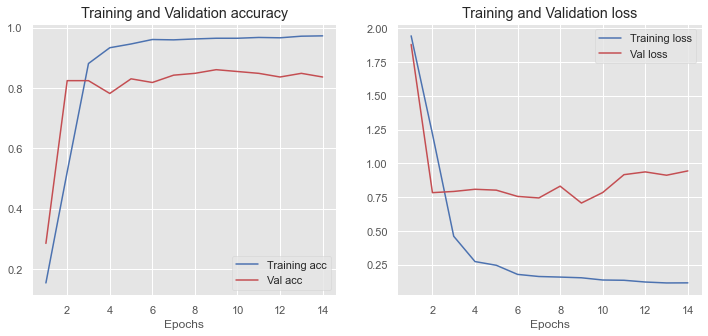

In [81]:
# Run  augmentation and encoding function on the accommodation data
output_dir = out('model_output/AttractAspectModelsAug4')
X_train_attract_w, y_train_attract_e, X_val_attract_w, y_val_attract_e, X_test_attract_w, y_test_attract_e = proc_aug(deleted, X_val_attract, y_val_attract, X_test_attract, y_val_attract)
model_attract_delete = create_model_a()
history_attract_del = run_mod(model_attract_delete, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)

In [84]:
#delete = evaluation(model_attract_delete, X_train_attract_w, X_val_attract_w, y_train_attract_e, y_val_attract_e)
print(delete[0])
print(delete[1])

0.9811742603778839
0.8448484778404236


In [85]:
training_results = pd.DataFrame([insert[0], rep[0],swap[0],delete[0]]).T
training_results.columns = ["Insertion", "Replace","Swap","Delete"]
training_results.index = ["Training Acc"]

val_results = pd.DataFrame([insert[1], rep[1],swap[1],delete[1]]).T
val_results.columns = ["Insertion", "Replace","Swap","Delete"]
val_results.index = ["Val Acc"]

all_results = pd.concat([training_results, val_results])
all_results

,Insertion,Replace,Swap,Delete
Training Acc,0.997614,0.994621,0.996553,0.981174
Val Acc,0.870909,0.843636,0.863636,0.844848


In [86]:
training_results

,Insertion,Replace,Swap,Delete
Training Acc,0.997614,0.994621,0.996553,0.981174


* Random insertion and swap seem to work the best of the augmented methods
* The best accuracies occurred in both of these models suggesting that either might work

# Section 7: Run the Best Augmented Model for Attractions

In [489]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 16
epochs = 50
class_weights_attract = {0:cw_attract[0],1:cw_attract[1],2:cw_attract[2],3:cw_attract[3],4:cw_attract[4],5:cw_attract[5],6:cw_attract[6]}

output_dir = out('model_output/AtractAspectModels')
callbacks = call(output_dir,5)
class_weights = class_weights_attract

Epoch 1/50
165/165 - 0s - loss: 1.9378 - accuracy: 0.1818 - val_loss: 1.7989 - val_accuracy: 0.3636
Epoch 2/50
165/165 - 0s - loss: 0.9635 - accuracy: 0.6470 - val_loss: 0.6467 - val_accuracy: 0.8364
Epoch 3/50
165/165 - 0s - loss: 0.2786 - accuracy: 0.9246 - val_loss: 0.6596 - val_accuracy: 0.8424
Epoch 4/50
165/165 - 0s - loss: 0.1529 - accuracy: 0.9606 - val_loss: 0.6622 - val_accuracy: 0.8424
Epoch 5/50
165/165 - 0s - loss: 0.0719 - accuracy: 0.9765 - val_loss: 0.7686 - val_accuracy: 0.8485
Epoch 6/50
165/165 - 0s - loss: 0.0739 - accuracy: 0.9807 - val_loss: 0.8079 - val_accuracy: 0.8606
Epoch 7/50
165/165 - 0s - loss: 0.0344 - accuracy: 0.9909 - val_loss: 0.8995 - val_accuracy: 0.8424



83/83 [==============================] - 0s 829us/step - loss: 0.0163 - accuracy: 0.9955
[0.01627928949892521, 0.9954545497894287]
6/6 [==============================] - 0s 998us/step - loss: 0.8995 - accuracy: 0.8424
[0.8995391726493835, 0.842424213886261]





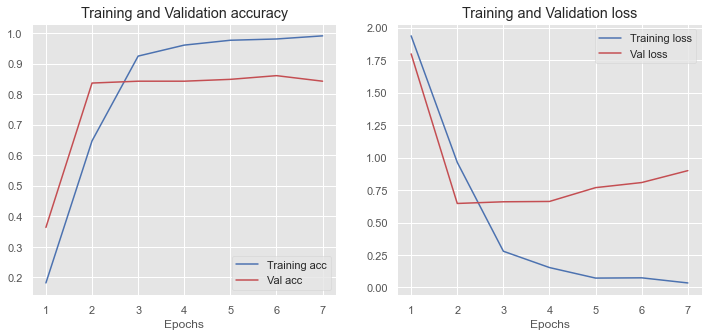

In [490]:
# Run encoding function on the augmented data and the original validation and test data
X_train_attract_aug_w, y_train_attract_aug_e, X_val_attract_aug_w, y_val_attract_aug_e, X_test_attract_aug_w, y_test_attract_aug_e = proc_aug(insertion, X_val_attract, y_val_attract, X_test_attract, y_val_attract)

# Run model using the word embeddings and the target encoded as one-hot encoding
model_attract_insert = create_model_a()
run_mod(model_attract_insert, X_train_attract_aug_w, X_val_attract_aug_w, y_train_attract_aug_e, y_val_attract_aug_e)

              precision    recall  f1-score   support

           0       0.96      0.77      0.85        30
           1       0.93      0.83      0.88        30
           2       0.88      0.93      0.90        15
           3       0.93      0.90      0.92        30
           4       0.94      0.85      0.89        20
           5       0.78      0.93      0.85        15
           6       0.67      0.88      0.76        25

    accuracy                           0.86       165
   macro avg       0.87      0.87      0.86       165
weighted avg       0.88      0.86      0.86       165



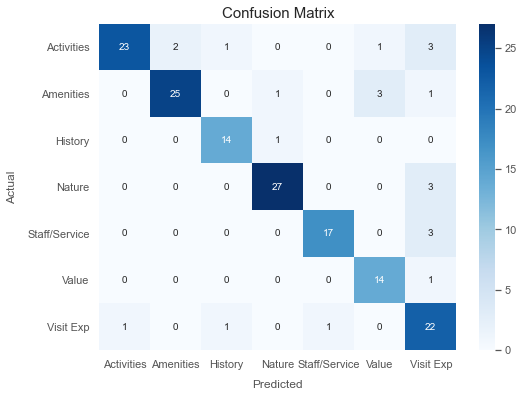



The model predicted: 23 aspects wrong from a total of: 165 predictions




In [491]:
df_pred_attract,df_wrong_attract,y_val_integer, y_pred_class, y_pred_prob = eval(model_attract_insert, output_dir,"/weights.06.hdf5",X_val_attract_aug_w, y_val_attract_aug_e,y_val_attract,label_attract)

In [492]:
results4 = metric_results(y_val_attract_e,y_val_integer,y_pred_class,y_pred_prob)
results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.860606,0.868455,0.870952,0.864195,0.970497


# Section 8: Pre-trained Word Embeddings

In [92]:
# Load the word embeddings model
embeddings_api = api.load("glove-wiki-gigaword-100")

In [93]:
# Check the top keyword from the pre-trained model from each category of the Arun dataset
embeddings_api.most_similar("room")

[('rooms', 0.8417543172836304),
 ('floor', 0.8001206517219543),
 ('bedroom', 0.7659991979598999),
 ('door', 0.7539054155349731),
 ('inside', 0.7500434517860413),
 ('filled', 0.7457945942878723),
 ('bathroom', 0.7396395802497864),
 ('upstairs', 0.7388456463813782),
 ('window', 0.7369202375411987),
 ('basement', 0.7362380027770996)]

In [94]:
embeddings_api.most_similar("food")

[('foods', 0.7469059824943542),
 ('supplies', 0.7264691591262817),
 ('products', 0.7225049138069153),
 ('meat', 0.7138239145278931),
 ('supply', 0.6732637882232666),
 ('feed', 0.6704155206680298),
 ('medicines', 0.6687097549438477),
 ('meals', 0.6630422472953796),
 ('coffee', 0.6627735495567322),
 ('goods', 0.6610530614852905)]

In [95]:
embeddings_api.most_similar("visit")

[('trip', 0.8311706185340881),
 ('visits', 0.8306344747543335),
 ('visiting', 0.8090822696685791),
 ('visited', 0.8073938488960266),
 ('meeting', 0.7426023483276367),
 ('attend', 0.7179381251335144),
 ('invitation', 0.699972927570343),
 ('met', 0.6998854279518127),
 ('here', 0.6958173513412476),
 ('arrived', 0.6912545561790466)]

In [96]:
# Amended function setting length of embeddings to 100 to match the pre-trained embeddings
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=100, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=100, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 100, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [97]:
# Apply function to X training, validation and test sets
accom_tok_p, X_train_accom_p, X_val_accom_p, X_test_accom_p = tok(X_train_accom, X_val_accom, X_test_accom)
food_tok_p,X_train_food_p, X_val_food_p, X_test_food_p = tok(X_train_food, X_val_food, X_test_food)
attract_tok_p,X_train_attract_p, X_val_attract_p, X_test_attract_p = tok(insertion.Nouns, X_val_attract, X_test_attract)

In [98]:
# Get vocab and size
accom_vocab = accom_tok_p.word_index.items()
food_vocab = food_tok_p.word_index.items()
attract_vocab = attract_tok_p.word_index.items()

accom_vocab_size = len(accom_vocab)+1
food_vocab_size = len(food_vocab)+1
attract_vocab_size = len(attract_vocab)+ 1

In [99]:
print(accom_vocab_size, food_vocab_size, attract_vocab_size)

798 593 1054


In [100]:
# Create weight matrices
embedding_matrix_accom = np.zeros((accom_vocab_size, 100))
embedding_matrix_food = np.zeros((food_vocab_size, 100))
embedding_matrix_attract = np.zeros((attract_vocab_size, 100))

In [101]:
print(embedding_matrix_accom.shape, embedding_matrix_food.shape, embedding_matrix_attract.shape)

(798, 100) (593, 100) (1054, 100)


In [102]:
# Function to create embedding matrices for model
def embed(vocab,embedding_matrix):
    for word, i in vocab:
        try:
            embedding_vector = embeddings_api[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except:
            pass
    return embedding_matrix

In [103]:
# Get embeddings using function
accom_embed = embed(accom_vocab, embedding_matrix_accom)
food_embed = embed(food_vocab,embedding_matrix_food)
attract_embed = embed(attract_vocab,embedding_matrix_attract)

In [104]:
print(accom_embed.shape, food_embed.shape, attract_embed.shape)

(798, 100) (593, 100) (1054, 100)


In [105]:
# Create model
def create_model_A():
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, weights = [embedding_matrix], output_dim = 100, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model


## Accommodation with pre-trained vectors

Epoch 1/50
111/111 - 2s - loss: 1.1165 - accuracy: 0.6109 - val_loss: 0.4749 - val_accuracy: 0.8559
Epoch 2/50
111/111 - 2s - loss: 0.4069 - accuracy: 0.8722 - val_loss: 0.3721 - val_accuracy: 0.8829
Epoch 3/50
111/111 - 2s - loss: 0.2570 - accuracy: 0.9257 - val_loss: 0.3916 - val_accuracy: 0.8739
Epoch 4/50
111/111 - 2s - loss: 0.1573 - accuracy: 0.9521 - val_loss: 0.3912 - val_accuracy: 0.8694
Epoch 5/50
111/111 - 2s - loss: 0.1278 - accuracy: 0.9628 - val_loss: 0.4902 - val_accuracy: 0.8694
Epoch 6/50
111/111 - 2s - loss: 0.1401 - accuracy: 0.9555 - val_loss: 0.4459 - val_accuracy: 0.8739
Epoch 7/50
111/111 - 2s - loss: 0.0828 - accuracy: 0.9780 - val_loss: 0.3422 - val_accuracy: 0.9009
Epoch 8/50
111/111 - 2s - loss: 0.0505 - accuracy: 0.9865 - val_loss: 0.6199 - val_accuracy: 0.8829
Epoch 9/50
111/111 - 2s - loss: 0.0569 - accuracy: 0.9876 - val_loss: 0.5338 - val_accuracy: 0.8829
Epoch 10/50
111/111 - 2s - loss: 0.0808 - accuracy: 0.9803 - val_loss: 0.6140 - val_accuracy: 0.9099

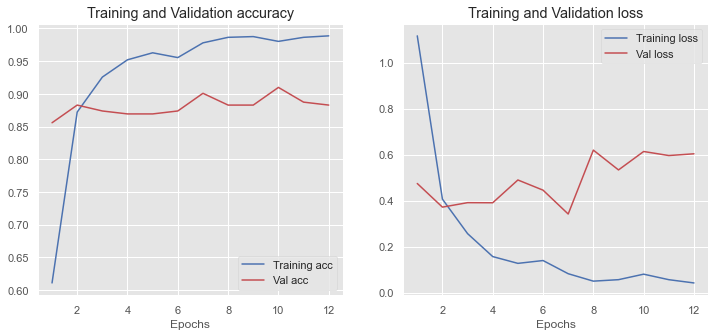

In [106]:
class_weights = class_weights_accom
embedding_matrix = accom_embed
vocab_size = accom_vocab_size
input_length = 100
output_dir = out('model_output/AccomAspectModelsWord2Vec')
callbacks = call(output_dir,5)

model5 = create_model_A()
history5 = run_mod(model5, X_train_accom_p, X_val_accom_p, y_train_accom_e, y_val_accom_e)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.82      0.94      0.88        35
           2       1.00      0.86      0.92        35
           3       0.91      0.91      0.91        22
           4       0.87      0.94      0.90        35
           5       0.91      0.89      0.90        35
           6       0.92      0.96      0.94        25

    accuracy                           0.90       222
   macro avg       0.91      0.90      0.90       222
weighted avg       0.91      0.90      0.90       222



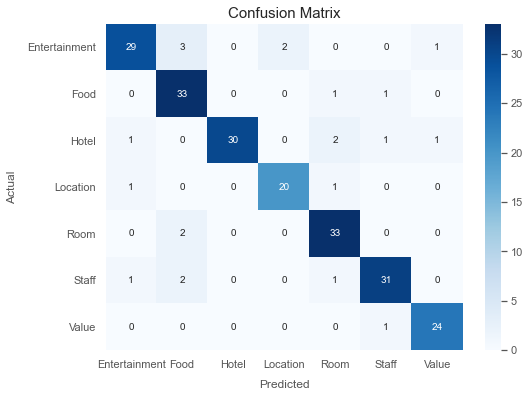



The model predicted: 22 aspects wrong from a total of: 222 predictions




In [107]:
labels_accom = ['Entertainment','Food','Hotel','Location','Room','Staff','Value']
df_pred_accom, df_wrong_accom, y_val_integer, y_pred_class, y_pred_prob = eval(model5, output_dir,"/weights.07.hdf5",X_val_accom_p, y_val_accom_e,y_val_accom,labels_accom)

In [108]:
results5 = metric_results(y_val_accom_e,y_val_integer,y_pred_class,y_pred_prob)
results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.900901,0.906229,0.903748,0.903097,0.993034


## Food with pre-trained vectors

In [109]:
# Model with output of 6 classes

def create_model_B():
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, weights = [embedding_matrix], output_dim = 100, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

Epoch 1/50
105/105 - 2s - loss: 0.9672 - accuracy: 0.6494 - val_loss: 0.3266 - val_accuracy: 0.9143
Epoch 2/50
105/105 - 2s - loss: 0.3543 - accuracy: 0.8929 - val_loss: 0.3167 - val_accuracy: 0.9286
Epoch 3/50
105/105 - 2s - loss: 0.2375 - accuracy: 0.9304 - val_loss: 0.2376 - val_accuracy: 0.9286
Epoch 4/50
105/105 - 2s - loss: 0.1649 - accuracy: 0.9524 - val_loss: 0.2282 - val_accuracy: 0.9476
Epoch 5/50
105/105 - 1s - loss: 0.1154 - accuracy: 0.9649 - val_loss: 0.2159 - val_accuracy: 0.9524
Epoch 6/50
105/105 - 2s - loss: 0.1071 - accuracy: 0.9696 - val_loss: 0.2272 - val_accuracy: 0.9524
Epoch 7/50
105/105 - 1s - loss: 0.0828 - accuracy: 0.9762 - val_loss: 0.2240 - val_accuracy: 0.9524
Epoch 8/50
105/105 - 2s - loss: 0.0845 - accuracy: 0.9774 - val_loss: 0.2552 - val_accuracy: 0.9524
Epoch 9/50
105/105 - 2s - loss: 0.0475 - accuracy: 0.9857 - val_loss: 0.2291 - val_accuracy: 0.9381
Epoch 10/50
105/105 - 2s - loss: 0.0567 - accuracy: 0.9827 - val_loss: 0.2206 - val_accuracy: 0.9571

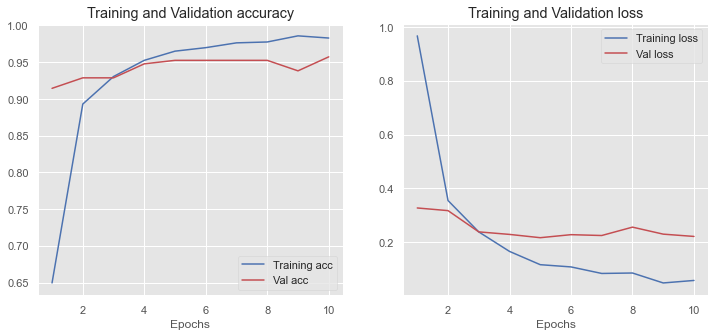

In [110]:
class_weights = class_weights_food
embedding_matrix = food_embed
vocab_size = food_vocab_size
input_length = 100
output_dir = out('model_output/FoodAspectModelsWord2Vec')
callbacks = call(output_dir,5)

model6 = create_model_B()
history6 = run_mod(model6, X_train_food_p, X_val_food_p, y_train_food_e, y_val_food_e)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.94      0.89      0.91        35
           2       0.92      1.00      0.96        35
           3       1.00      1.00      1.00        35
           4       0.97      0.94      0.96        35
           5       0.94      0.94      0.94        35

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



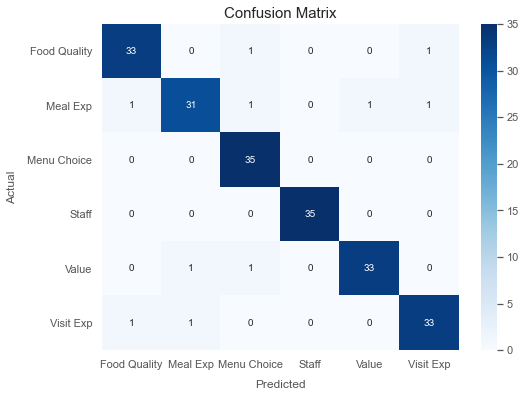



The model predicted: 10 aspects wrong from a total of: 210 predictions




In [112]:
label_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
df_pred_food, df_wrong_food, y_val_integer, y_pred_class, y_pred_prob = eval(model6, output_dir,"/weights.05.hdf5",X_val_food_p, y_val_food_e,y_val_food,label_food)

In [113]:
results6 = metric_results(y_val_food_e,y_val_integer,y_pred_class,y_pred_prob)
results6

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.952381,0.952792,0.952381,0.952151,0.995156


## Attractions with pre-trained vectors

Epoch 1/50
165/165 - 2s - loss: 1.3157 - accuracy: 0.4966 - val_loss: 0.6928 - val_accuracy: 0.8182
Epoch 2/50
165/165 - 2s - loss: 0.6037 - accuracy: 0.7958 - val_loss: 0.5861 - val_accuracy: 0.8606
Epoch 3/50
165/165 - 2s - loss: 0.3920 - accuracy: 0.8727 - val_loss: 0.5355 - val_accuracy: 0.8545
Epoch 4/50
165/165 - 2s - loss: 0.2642 - accuracy: 0.9152 - val_loss: 0.5366 - val_accuracy: 0.8667
Epoch 5/50
165/165 - 2s - loss: 0.2020 - accuracy: 0.9341 - val_loss: 0.5680 - val_accuracy: 0.8485
Epoch 6/50
165/165 - 2s - loss: 0.1136 - accuracy: 0.9602 - val_loss: 0.5238 - val_accuracy: 0.8667
Epoch 7/50
165/165 - 2s - loss: 0.1275 - accuracy: 0.9587 - val_loss: 0.5836 - val_accuracy: 0.8727
Epoch 8/50
165/165 - 2s - loss: 0.0879 - accuracy: 0.9708 - val_loss: 0.6943 - val_accuracy: 0.8788
Epoch 9/50
165/165 - 2s - loss: 0.0693 - accuracy: 0.9788 - val_loss: 0.6324 - val_accuracy: 0.8848
Epoch 10/50
165/165 - 2s - loss: 0.0751 - accuracy: 0.9761 - val_loss: 0.7143 - val_accuracy: 0.8848

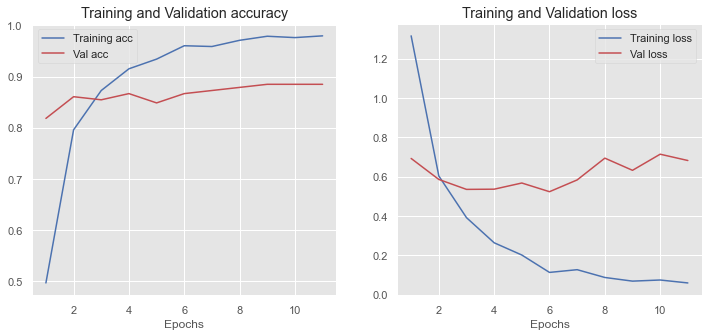

In [114]:
class_weights = class_weights_attract
embedding_matrix = attract_embed
vocab_size = attract_vocab_size
input_length = 100
output_dir = out('model_output/AttractAspectModelsWord2Vec')
callbacks = call(output_dir,5)

model7 = create_model_A()
history7 = run_mod(model7, X_train_attract_p, X_val_attract_p, y_train_attract_aug_e, y_val_attract_aug_e)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        30
           1       0.90      0.90      0.90        30
           2       0.93      0.87      0.90        15
           3       0.97      0.93      0.95        30
           4       0.95      0.95      0.95        20
           5       0.76      0.87      0.81        15
           6       0.79      0.92      0.85        25

    accuracy                           0.88       165
   macro avg       0.88      0.89      0.88       165
weighted avg       0.89      0.88      0.89       165



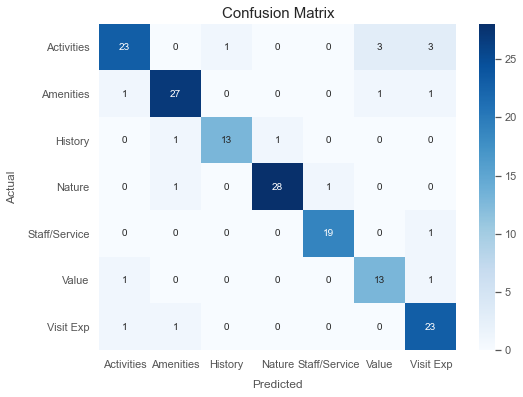



The model predicted: 19 aspects wrong from a total of: 165 predictions




In [116]:
label_attract = ["Activities","Amenities","History","Nature","Staff/Service","Value","Visit Exp"]
df_pred_attract,df_wrong_attract,y_val_integer, y_pred_class, y_pred_prob = eval(model7, output_dir,"/weights.09.hdf5",X_val_attract_p, y_val_attract_e,y_val_attract,label_attract)

In [117]:
results7 = metric_results(y_val_attract_e,y_val_integer,y_pred_class,y_pred_prob)
results7

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.884848,0.883788,0.88619,0.883069,0.98234


# Section 9: Train Custom Word2Vec Embeddings

In [118]:
from gensim.models import Word2Vec

In [119]:
X_train_attract_ce = insertion.Nouns

In [120]:
X_train_accom_ce = X_train_accom.apply(lambda x: gensim.utils.simple_preprocess(x))
X_train_food_ce = X_train_food.apply(lambda x: gensim.utils.simple_preprocess(x))
X_train_attract_ce = insertion.Nouns.apply(lambda x: gensim.utils.simple_preprocess(x))

X_val_accom_ce = X_val_accom.apply(lambda x: gensim.utils.simple_preprocess(x))
X_val_food_ce = X_val_food.apply(lambda x: gensim.utils.simple_preprocess(x))
X_val_attract_ce = X_val_attract.apply(lambda x: gensim.utils.simple_preprocess(x))

In [121]:
print(len(X_train_accom_ce), len(X_train_food_ce), len(X_train_attract_ce))

1776 1680 2640


In [122]:
# Create skipgram word embeddings with vector size 100, window of 3 words forward and 2 behind the target, 
# with words that appear at least once. Window is only 3 as this is based just on nouns so the review lines are short.
model_accom  = Word2Vec(X_train_accom_ce,vector_size = 100, window = 3, min_count = 1)
model_food = Word2Vec(X_train_food_ce, vector_size = 100, window = 3, min_count = 1)
model_attract = Word2Vec(X_train_attract_ce, vector_size = 100, window = 3, min_count = 1)

In [123]:
# Have a look at 100 items
print(model_accom.wv.index_to_key[0:100],end = "")

['hotel', 'staff', 'location', 'food', 'room', 'value', 'money', 'entertainment', 'service', 'breakfast', 'choice', 'bed', 'restaurant', 'fun', 'helpful', 'good', 'play', 'quality', 'pool', 'night', 'reception', 'show', 'holiday', 'bathroom', 'superb', 'family', 'selection', 'kid', 'area', 'ok', 'lot', 'waste', 'meal', 'view', 'floor', 'party', 'plenty', 'noisy', 'ground', 'child', 'tidy', 'menu', 'place', 'experience', 'price', 'centre', 'activity', 'lack', 'customer', 'member', 'dinner', 'fair', 'comfy', 'shower', 'pay', 'slide', 'fab', 'tasty', 'facility', 'adult', 'need', 'fault', 'pub', 'security', 'evening', 'kind', 'size', 'town', 'amount', 'problem', 'side', 'towel', 'number', 'polite', 'sea', 'thing', 'rude', 'stay', 'morning', 'weekend', 'venue', 'drink', 'sleep', 'stage', 'fairground', 'door', 'lunch', 'complain', 'tea', 'variety', 'complaint', 'decor', 'host', 'house', 'dirty', 'buffet', 'thanks', 'visit', 'wine', 'option']

In [124]:
# Check the most similar words as before and see if they make sense and how they compare to the pre-trained model
model_accom.wv.most_similar(positive = ['room'],topn = 10)

[('quiz', 0.29594212770462036),
 ('fun', 0.29225343465805054),
 ('fairground', 0.27386826276779175),
 ('mod', 0.2733832597732544),
 ('bike', 0.26306596398353577),
 ('selection', 0.2515861392021179),
 ('travel', 0.2514866590499878),
 ('cereal', 0.23587961494922638),
 ('steak', 0.23421654105186462),
 ('location', 0.23336449265480042)]

In [125]:
model_food.wv.most_similar(positive = ['food'],topn = 10)

[('distance', 0.36335116624832153),
 ('cafe', 0.3345734477043152),
 ('selection', 0.32853981852531433),
 ('suffer', 0.2839663326740265),
 ('ale', 0.2810397446155548),
 ('average', 0.27310967445373535),
 ('area', 0.2717341184616089),
 ('ambience', 0.2615872919559479),
 ('son', 0.25238215923309326),
 ('terrific', 0.24861350655555725)]

In [126]:
model_attract.wv.most_similar(positive = ['visit'],topn = 10)

[('chew', 0.47415468096733093),
 ('play', 0.44152987003326416),
 ('ticket', 0.3970584273338318),
 ('ðÿ', 0.34929949045181274),
 ('cake', 0.33517658710479736),
 ('compare', 0.3340431749820709),
 ('beauty', 0.32926687598228455),
 ('place', 0.32477840781211853),
 ('passionate', 0.3175033926963806),
 ('block', 0.3157424032688141)]

Most of these don't make a lot of sense!

In [127]:
# Function to create embedding matrices for model
def embed_custom(vocab,embedding_matrix):
    for word, i in vocab:
        try:
            embedding_vector = model_accom[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except:
            pass
    return embedding_matrix

In [128]:
accom_embed_custom = embed(accom_vocab, embedding_matrix_accom)
food_embed_custom = embed(food_vocab,embedding_matrix_food)
attract_embed_custom = embed(attract_vocab,embedding_matrix_attract)

In [129]:
class_weights = class_weights_accom
embedding_matrix = accom_embed_custom
vocab_size = accom_vocab_size
input_length = 100
output_dim = 100
output_dir = out('model_output/AccomAspectModelsCustom')
callbacks = call(output_dir,5)

## Accommodation

Epoch 1/50
111/111 - 2s - loss: 1.1619 - accuracy: 0.5631 - val_loss: 0.5166 - val_accuracy: 0.8559
Epoch 2/50
111/111 - 2s - loss: 0.4688 - accuracy: 0.8553 - val_loss: 0.4175 - val_accuracy: 0.8739
Epoch 3/50
111/111 - 2s - loss: 0.2475 - accuracy: 0.9234 - val_loss: 0.3679 - val_accuracy: 0.8649
Epoch 4/50
111/111 - 2s - loss: 0.1709 - accuracy: 0.9527 - val_loss: 0.4984 - val_accuracy: 0.8694
Epoch 5/50
111/111 - 2s - loss: 0.1503 - accuracy: 0.9561 - val_loss: 0.3772 - val_accuracy: 0.8784
Epoch 6/50
111/111 - 2s - loss: 0.1083 - accuracy: 0.9673 - val_loss: 0.4371 - val_accuracy: 0.8964
Epoch 7/50
111/111 - 2s - loss: 0.0610 - accuracy: 0.9820 - val_loss: 0.4245 - val_accuracy: 0.8739
Epoch 8/50
111/111 - 2s - loss: 0.0665 - accuracy: 0.9831 - val_loss: 0.5423 - val_accuracy: 0.8694



56/56 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 0.9949
[0.017954913899302483, 0.9949324131011963]
7/7 [==============================] - 0s 2ms/step - loss: 0.5423 -

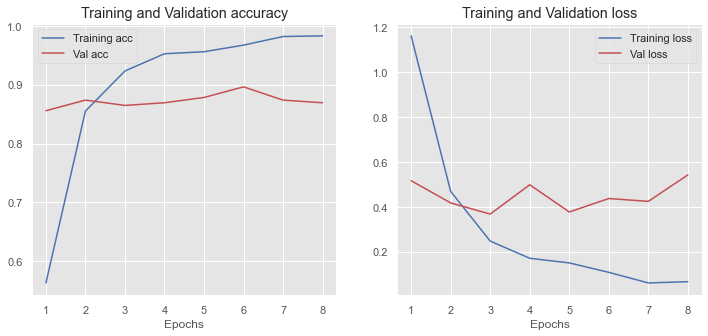

In [130]:
model8 = create_model_A()
run_mod(model8, X_train_accom_p, X_val_accom_p, y_train_accom_e, y_val_accom_e)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.87      0.94      0.90        35
           2       1.00      0.83      0.91        35
           3       1.00      0.82      0.90        22
           4       0.80      0.94      0.87        35
           5       0.97      0.86      0.91        35
           6       0.80      0.96      0.87        25

    accuracy                           0.90       222
   macro avg       0.91      0.89      0.90       222
weighted avg       0.91      0.90      0.90       222



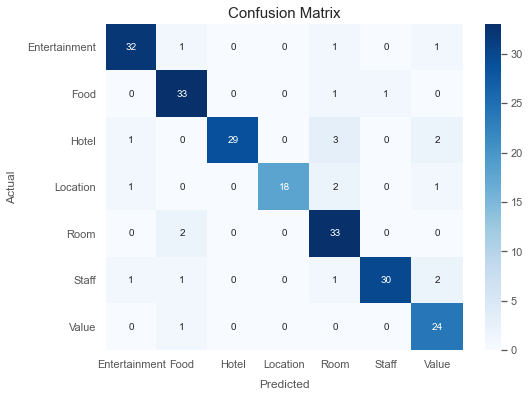



The model predicted: 23 aspects wrong from a total of: 222 predictions




In [131]:
labels_accom = ['Entertainment','Food','Hotel','Location','Room','Staff','Value']
df_pred_accom, df_wrong_accom, y_val_integer, y_pred_class, y_pred_prob = eval(model8, output_dir,"/weights.06.hdf5",X_val_accom_p, y_val_accom_e,y_val_accom,labels_accom)

In [132]:
results8 = metric_results(y_val_accom_e,y_val_integer,y_pred_class,y_pred_prob)
results8

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.896396,0.907904,0.894842,0.896412,0.99145


## Food

In [133]:
class_weights = class_weights_food
embedding_matrix = food_embed_custom
vocab_size = food_vocab_size
input_length = 100
output_dim = 100
output_dir = out('model_output/FoodAspectModelsCustom')
callbacks = call(output_dir,5)

Epoch 1/50
105/105 - 2s - loss: 1.0097 - accuracy: 0.6304 - val_loss: 0.3280 - val_accuracy: 0.8905
Epoch 2/50
105/105 - 2s - loss: 0.3527 - accuracy: 0.8857 - val_loss: 0.2186 - val_accuracy: 0.9429
Epoch 3/50
105/105 - 1s - loss: 0.2155 - accuracy: 0.9357 - val_loss: 0.1953 - val_accuracy: 0.9524
Epoch 4/50
105/105 - 2s - loss: 0.1468 - accuracy: 0.9542 - val_loss: 0.2264 - val_accuracy: 0.9381
Epoch 5/50
105/105 - 2s - loss: 0.1383 - accuracy: 0.9637 - val_loss: 0.3063 - val_accuracy: 0.9190
Epoch 6/50
105/105 - 1s - loss: 0.0861 - accuracy: 0.9714 - val_loss: 0.2400 - val_accuracy: 0.9381
Epoch 7/50
105/105 - 2s - loss: 0.0691 - accuracy: 0.9768 - val_loss: 0.2038 - val_accuracy: 0.9619
Epoch 8/50
105/105 - 2s - loss: 0.0407 - accuracy: 0.9887 - val_loss: 0.2360 - val_accuracy: 0.9619



53/53 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9946
[0.03049478493630886, 0.9946428537368774]
7/7 [==============================] - 0s 3ms/step - loss: 0.2360 - 

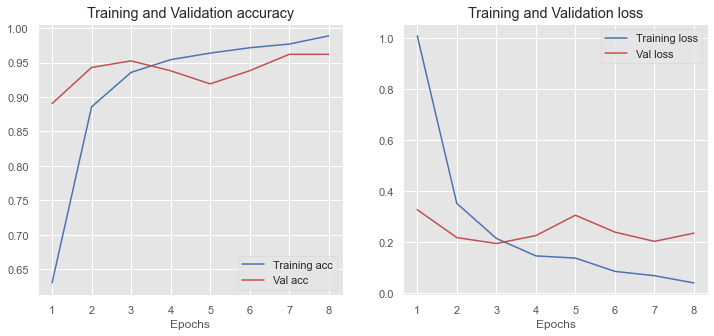

In [134]:
model9 = create_model_B()
run_mod(model9, X_train_food_p, X_val_food_p, y_train_food_e, y_val_food_e)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.97      0.89      0.93        35
           2       0.92      1.00      0.96        35
           3       1.00      1.00      1.00        35
           4       0.97      0.97      0.97        35
           5       0.94      0.97      0.96        35

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



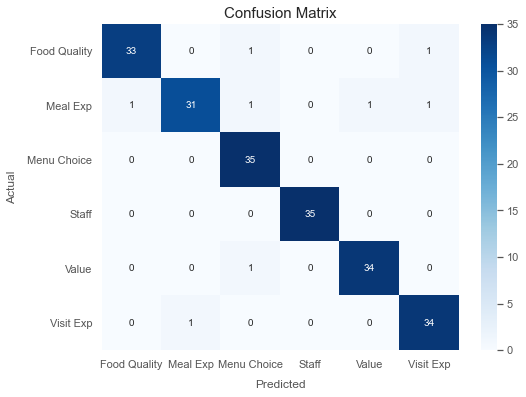



The model predicted: 8 aspects wrong from a total of: 210 predictions




In [135]:
label_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
df_pred_food, df_wrong_food, y_val_integer, y_pred_class, y_pred_prob = eval(model9, output_dir,"/weights.07.hdf5",X_val_food_p, y_val_food_e,y_val_food,label_food)

In [136]:
results9 = metric_results(y_val_food_e,y_val_integer,y_pred_class,y_pred_prob)
results9

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961905,0.962711,0.961905,0.961662,0.996517


## Attractions

In [137]:
class_weights = class_weights_attract
embedding_matrix = attract_embed_custom
vocab_size = attract_vocab_size
input_length = 100
output_dir = out('model_output/AttractAspectModelsCustom')
callbacks = call(output_dir,5)

Epoch 1/50
165/165 - 2s - loss: 1.3225 - accuracy: 0.4992 - val_loss: 0.6799 - val_accuracy: 0.8303
Epoch 2/50
165/165 - 2s - loss: 0.6260 - accuracy: 0.7928 - val_loss: 0.5145 - val_accuracy: 0.8303
Epoch 3/50
165/165 - 2s - loss: 0.3897 - accuracy: 0.8716 - val_loss: 0.6786 - val_accuracy: 0.8545
Epoch 4/50
165/165 - 2s - loss: 0.2540 - accuracy: 0.9159 - val_loss: 0.5310 - val_accuracy: 0.8545
Epoch 5/50
165/165 - 2s - loss: 0.1992 - accuracy: 0.9277 - val_loss: 0.5060 - val_accuracy: 0.8788
Epoch 6/50
165/165 - 2s - loss: 0.1462 - accuracy: 0.9561 - val_loss: 0.5974 - val_accuracy: 0.8606
Epoch 7/50
165/165 - 2s - loss: 0.1283 - accuracy: 0.9598 - val_loss: 0.4893 - val_accuracy: 0.8667
Epoch 8/50
165/165 - 2s - loss: 0.0711 - accuracy: 0.9777 - val_loss: 0.4845 - val_accuracy: 0.8667
Epoch 9/50
165/165 - 2s - loss: 0.0746 - accuracy: 0.9773 - val_loss: 0.6644 - val_accuracy: 0.8727
Epoch 10/50
165/165 - 2s - loss: 0.1131 - accuracy: 0.9720 - val_loss: 0.7676 - val_accuracy: 0.8424

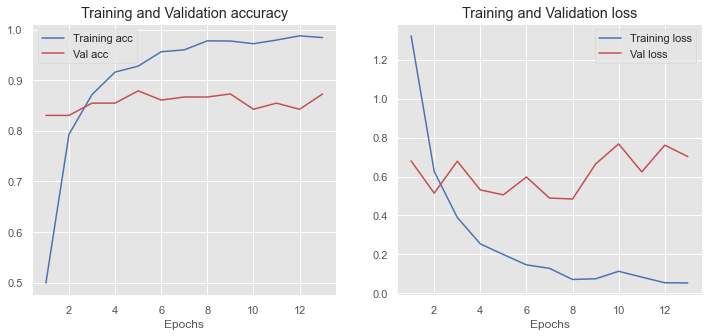

In [138]:
model10 = create_model_A()
history10 = run_mod(model10, X_train_attract_p, X_val_attract_p, y_train_attract_aug_e, y_val_attract_aug_e)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80        30
           1       0.93      0.93      0.93        30
           2       0.93      0.87      0.90        15
           3       0.88      0.97      0.92        30
           4       0.95      0.90      0.92        20
           5       0.87      0.87      0.87        15
           6       0.76      0.88      0.81        25

    accuracy                           0.88       165
   macro avg       0.88      0.88      0.88       165
weighted avg       0.88      0.88      0.88       165



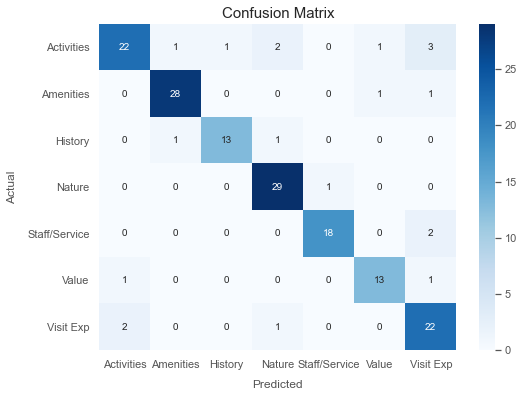



The model predicted: 20 aspects wrong from a total of: 165 predictions




In [139]:
label_attract = ["Activities","Amenities","History","Nature","Staff/Service","Value","Visit Exp"]
df_pred_attract,df_wrong_attract,y_val_integer, y_pred_class, y_pred_prob = eval(model10, output_dir,"/weights.05.hdf5",X_val_attract_p, y_val_attract_aug_e,y_val_attract,label_attract)

In [140]:
results10 = metric_results(y_val_attract_aug_e,y_val_integer,y_pred_class,y_pred_prob)
results10

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.878788,0.884764,0.878095,0.879297,0.980987


# Section 10: Summary Tables

In [494]:
model_sum = pd.concat([results1, results2, results3,results4, results5, results6, results7,results8,results9,results10])
model_sum.index = ["Accommodation","Food","Attractions","Attractions Aug", "Accommodation WE", "Food WE", 
                   "Attractions Aug WE","Accommodation CE","Food CE","Attract Aug CE"]
model_sum.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.961905,0.962588,0.961905,0.961672,0.995483
Food CE,0.961905,0.962711,0.961905,0.961662,0.996517
Food WE,0.952381,0.952792,0.952381,0.952151,0.995156
Accommodation,0.909910,0.919263,0.911911,0.914381,0.989870
Accommodation WE,0.900901,0.906229,0.903748,0.903097,0.993034
Accommodation CE,0.896396,0.907904,0.894842,0.896412,0.991450
Attractions Aug WE,0.884848,0.883788,0.886190,0.883069,0.982340
Attract Aug CE,0.878788,0.884764,0.878095,0.879297,0.980987
Attractions Aug,0.860606,0.868455,0.870952,0.864195,0.970497
Attractions,0.848485,0.844832,0.850000,0.845665,0.966512


In [495]:
model_sum.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food CE,0.961905,0.962711,0.961905,0.961662,0.996517
Food,0.961905,0.962588,0.961905,0.961672,0.995483
Food WE,0.952381,0.952792,0.952381,0.952151,0.995156
Accommodation WE,0.900901,0.906229,0.903748,0.903097,0.993034
Accommodation CE,0.896396,0.907904,0.894842,0.896412,0.991450
Accommodation,0.909910,0.919263,0.911911,0.914381,0.989870
Attractions Aug WE,0.884848,0.883788,0.886190,0.883069,0.982340
Attract Aug CE,0.878788,0.884764,0.878095,0.879297,0.980987
Attractions Aug,0.860606,0.868455,0.870952,0.864195,0.970497
Attractions,0.848485,0.844832,0.850000,0.845665,0.966512


In [496]:
model_sum.sort_values(by = "F1",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.961905,0.962588,0.961905,0.961672,0.995483
Food CE,0.961905,0.962711,0.961905,0.961662,0.996517
Food WE,0.952381,0.952792,0.952381,0.952151,0.995156
Accommodation,0.909910,0.919263,0.911911,0.914381,0.989870
Accommodation WE,0.900901,0.906229,0.903748,0.903097,0.993034
Accommodation CE,0.896396,0.907904,0.894842,0.896412,0.991450
Attractions Aug WE,0.884848,0.883788,0.886190,0.883069,0.982340
Attract Aug CE,0.878788,0.884764,0.878095,0.879297,0.980987
Attractions Aug,0.860606,0.868455,0.870952,0.864195,0.970497
Attractions,0.848485,0.844832,0.850000,0.845665,0.966512


In [497]:
model_sum.sort_values(by = "Recall",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.961905,0.962588,0.961905,0.961672,0.995483
Food CE,0.961905,0.962711,0.961905,0.961662,0.996517
Food WE,0.952381,0.952792,0.952381,0.952151,0.995156
Accommodation,0.909910,0.919263,0.911911,0.914381,0.989870
Accommodation WE,0.900901,0.906229,0.903748,0.903097,0.993034
Accommodation CE,0.896396,0.907904,0.894842,0.896412,0.991450
Attractions Aug WE,0.884848,0.883788,0.886190,0.883069,0.982340
Attract Aug CE,0.878788,0.884764,0.878095,0.879297,0.980987
Attractions Aug,0.860606,0.868455,0.870952,0.864195,0.970497
Attractions,0.848485,0.844832,0.850000,0.845665,0.966512


# Section 11: Hyperparameter Tuning

There are many different parameters that can be tuned in a network model so only learning rate and batch size are covered using randomized grid search as this is compute intensive.

The hyperparameter tuning uses the same metric as the model (roc_auc_score)

Tutorial referred to:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [487]:
from sklearn.model_selection import RandomizedSearchCV

In [526]:
# Using custom embeddings as best model
embedding_matrix = food_embed_custom
class_weights_food 
vocab_size = food_vocab_size
input_length = 100
output_dim = 100
output_dir = out('model_output/FoodAspectModelsHyper')
callbacks = call(output_dir,5)

## Food Category

### Batch Sizes, Learning Rate, Initialisation,Drop-out rate, Activation function

In [527]:
# Model

def create_model_C(batch_size, learning_rate, initializer, dropout_rate, activation):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, weights = [embedding_matrix], output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation=activation, kernel_initializer=initializer))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(256,activation = activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(128,activation = activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(6, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
        
model = KerasClassifier(build_fn = create_model_C,verbose = 0, epochs = 50, batch_size = batch_size)

In [528]:
model = KerasClassifier(build_fn = create_model_C,verbose = 0)
learning_rate = [0.001, 0.01, 0.1]
batch_size = [8,16,32,64]
initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_distribs = {"learning_rate":learning_rate, "batch_size" : batch_size, "initializer":initializer,
                  "dropout_rate" :dropout_rate, "activation": activation}
clf = RandomizedSearchCV(model, param_distribs, cv = 3,scoring = 'roc_auc_ovr')
clf.fit(X_train_food_p, y_train_food_e)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002593B25A848>,
                   param_distributions={'activation': ['softmax', 'softplus',
                                                       'softsign', 'relu',
                                                       'tanh', 'sigmoid',
                                                       'hard_sigmoid',
                                                       'linear'],
                                        'batch_size': [8, 16, 32, 64],
                                        'dropout_rate': [0.0, 0.1, 0.2, 0.3,
                                                         0.4, 0.5, 0.6, 0.7,
                                                         0.8, 0.9],
                                        'initializer': ['uniform',
                                                        'lecun_uniform',
                                                       

In [529]:
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean,parameter)

0.9875401487872787 {'learning_rate': 0.001, 'initializer': 'zero', 'dropout_rate': 0.1, 'batch_size': 16, 'activation': 'softsign'}
0.7717229445814522 {'learning_rate': 0.001, 'initializer': 'glorot_normal', 'dropout_rate': 0.9, 'batch_size': 64, 'activation': 'sigmoid'}
0.9875401487872787 {'learning_rate': 0.001, 'initializer': 'zero', 'dropout_rate': 0.1, 'batch_size': 16, 'activation': 'softsign'}
0.8981250001295282 {'learning_rate': 0.01, 'initializer': 'glorot_normal', 'dropout_rate': 0.0, 'batch_size': 64, 'activation': 'hard_sigmoid'}
0.9843148896452374 {'learning_rate': 0.001, 'initializer': 'zero', 'dropout_rate': 0.3, 'batch_size': 16, 'activation': 'linear'}
0.5 {'learning_rate': 0.1, 'initializer': 'glorot_normal', 'dropout_rate': 0.7, 'batch_size': 32, 'activation': 'hard_sigmoid'}
0.5226247479804907 {'learning_rate': 0.1, 'initializer': 'normal', 'dropout_rate': 0.9, 'batch_size': 8, 'activation': 'hard_sigmoid'}
0.5 {'learning_rate': 0.1, 'initializer': 'zero', 'dropout_

Tuned model not improved roc score of 0.9965147

## Attractions Category

In [530]:
# Using embedding matrix for pre-trained word embeddings as best model
class_weights = class_weights_attract
embedding_matrix = attract_embed
vocab_size = attract_vocab_size
input_length = 100
output_dir = out('model_output/AttractAspectModelsHyper')
callbacks = call(output_dir,5)

In [531]:
# Model

def create_model_D(batch_size, learning_rate, initializer, dropout_rate,activation):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, weights = [embedding_matrix], output_dim = output_dim, input_length = input_length))
    model.add(Flatten())
    model.add(Dense(512, activation=activation, kernel_initializer=initializer))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(256,activation = activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(128,activation = activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(7, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
        
model = KerasClassifier(build_fn = create_model_C,verbose = 0, epochs = 50, batch_size = batch_size)

In [532]:
model = KerasClassifier(build_fn = create_model_D,verbose = 0)
learning_rate = [0.001, 0.01, 0.1]
batch_size = [8,16,32,64]
initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_distribs = {"learning_rate":learning_rate, "batch_size" : batch_size, "initializer":initializer,
                  "dropout_rate" :dropout_rate, "activation":activation}
clf = RandomizedSearchCV(model, param_distribs, cv = 3,scoring = 'roc_auc_ovr')
clf.fit(X_train_attract_p, y_train_attract_aug_e)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000025A431EB248>,
                   param_distributions={'activation': ['softmax', 'softplus',
                                                       'softsign', 'relu',
                                                       'tanh', 'sigmoid',
                                                       'hard_sigmoid',
                                                       'linear'],
                                        'batch_size': [8, 16, 32, 64],
                                        'dropout_rate': [0.0, 0.1, 0.2, 0.3,
                                                         0.4, 0.5, 0.6, 0.7,
                                                         0.8, 0.9],
                                        'initializer': ['uniform',
                                                        'lecun_uniform',
                                                       

In [533]:
print(clf.best_score_, clf.best_params_)
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean,parameter)

0.9259478261552537 {'learning_rate': 0.001, 'initializer': 'he_normal', 'dropout_rate': 0.4, 'batch_size': 8, 'activation': 'hard_sigmoid'}
0.4900199420932558 {'learning_rate': 0.001, 'initializer': 'normal', 'dropout_rate': 0.6, 'batch_size': 64, 'activation': 'softmax'}
0.5670537892803272 {'learning_rate': 0.01, 'initializer': 'he_uniform', 'dropout_rate': 0.0, 'batch_size': 16, 'activation': 'softmax'}
0.500623106993158 {'learning_rate': 0.1, 'initializer': 'uniform', 'dropout_rate': 0.8, 'batch_size': 32, 'activation': 'sigmoid'}
0.9162703596782275 {'learning_rate': 0.001, 'initializer': 'he_uniform', 'dropout_rate': 0.0, 'batch_size': 64, 'activation': 'softplus'}
0.9259478261552537 {'learning_rate': 0.001, 'initializer': 'he_normal', 'dropout_rate': 0.4, 'batch_size': 8, 'activation': 'hard_sigmoid'}
0.8622641888349621 {'learning_rate': 0.01, 'initializer': 'glorot_normal', 'dropout_rate': 0.6, 'batch_size': 16, 'activation': 'linear'}
0.8994727389681372 {'learning_rate': 0.001, 

Tuning did not improve ROC score of 0.9823

# Section 12:  Best Model Against the Test Set

### Food - Best Model 9 Against Test Set

In [538]:
embedding_matrix = food_embed_custom
class_weights = class_weights_food # not needed but called in the evaluation function
vocab_size = food_vocab_size
batch_size = 16
epochs = 50
input_length = 100
output_dim = 100

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.89      0.91      0.90        35
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        35
           4       0.95      1.00      0.97        35
           5       0.91      0.83      0.87        35

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



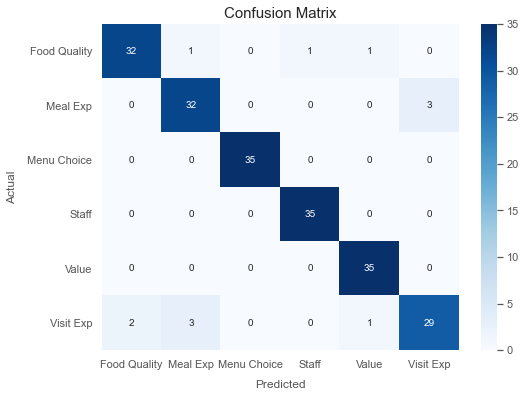



The model predicted: 12 aspects wrong from a total of: 210 predictions




In [539]:
model9.load_weights('model_output/FoodAspectModelsCustom/weights.07.hdf5')
y_pred_prob = model9.predict(X_test_food_p)
y_pred_class = np.argmax(model9.predict(X_test_food_p), axis=-1)
y_val_integer = np.argmax(y_test_food_e, axis=1)
df_pred = pd.DataFrame(list(zip(y_val_integer, y_test_food,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
class_conf(y_val_integer,y_pred_class,label_food)
print("\n")
print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
print("\n")


In [540]:
results12 = metric_results(y_test_food_e,y_val_integer,y_pred_class,y_pred_prob)
results12.index = ["Best Model (Test)"]
results12

,Accuracy,Precision,Recall,F1,ROCAUC
Best Model (Test),0.942857,0.942414,0.942857,0.942126,0.994776


### Attractions Best Model 10

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.90      0.87      0.88        30
           2       0.88      0.93      0.90        15
           3       0.87      0.90      0.89        30
           4       0.93      0.65      0.76        20
           5       0.93      0.87      0.90        15
           6       0.63      0.76      0.69        25

    accuracy                           0.84       165
   macro avg       0.85      0.83      0.84       165
weighted avg       0.85      0.84      0.84       165



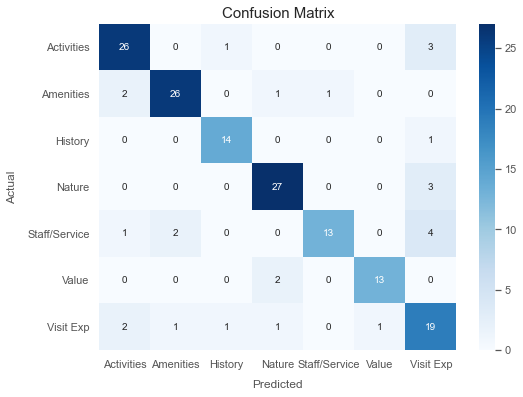



The model predicted: 27 aspects wrong from a total of: 165 predictions




In [577]:
model7.load_weights('model_output/AttractAspectModelsWord2Vec/weights.09.hdf5')
y_pred_prob = model7.predict(X_test_attract_p)
y_pred_class = np.argmax(model7.predict(X_test_attract_p), axis=-1)
y_test_integer = np.argmax(y_test_attract_e, axis=1)
df_pred = pd.DataFrame(list(zip(y_test_integer, y_test_attract,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
class_conf(y_test_integer,y_pred_class,label_attract)
print("\n")
print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
print("\n")

In [579]:
results13 = metric_results(y_test_attract_e,y_test_integer,y_pred_class,y_pred_prob)
results13.index = ["Best Model (Test)"]
results13

,Accuracy,Precision,Recall,F1,ROCAUC
Best Model (Test),0.836364,0.853101,0.834762,0.839208,0.968868
